![CESI](./Logo_cesi.png)

# Projet Leyenda
## Livrable 1 - Classification binaire
|Auteurs|
|---|
|Karim Salhi
|Corentin Devrouete
|Hugo Larose
|Pierre-Alain Tietz

### Importation des librairies

Expliquer brièvement à quoi sert chaque librairie

In [5]:
import keras
import numpy
import sklearn
import tensorflow
import matplotlib
import pydot
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as kb
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from sklearn.metrics import roc_curve,RocCurveDisplay,auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print(tf.__version__)

2.7.0


### Initialisation des paramètres

A quoi sert chaque paramètre

In [3]:
BATCH_SIZE = 16
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
VALIDATION_SPLIT = 0.2
EPOCHS = 50
STEPS_PER_EPOCH = 1000

In [15]:
PATH_DATASET = os.path.join('D:\\CESI\\A5\\Data\\Datasets\\Unzip')
PATH_DATASET_TEST = os.path.join('D:\\CESI\\A5\\Data\\Datasets\\Test')
PATH_SAVE_MODEL = os.path.join('C:\\Users\\karim\\Documents\\GitHub\\Leyenda\\Livrable1\\model\\cnn_real.h5')

### Création des jeux de données

Pourquoi on le fait, ...

In [8]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory (
    PATH_DATASET,
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    validation_split = VALIDATION_SPLIT,
    batch_size = BATCH_SIZE,
    seed = 42,
    subset = 'training',
)

dataset_test = tf.keras.preprocessing.image_dataset_from_directory (
    PATH_DATASET,
    image_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    validation_split = VALIDATION_SPLIT,
    batch_size = BATCH_SIZE,
    seed = 42,
    subset = 'validation',
)

CLASSES = dataset_train.class_names
NB_CLASSES = len(dataset_train.class_names)
print(f'Le dataset comporte {NB_CLASSES} classes : {CLASSES}')

Found 20000 files belonging to 2 classes.
Using 16000 files for training.
Found 20000 files belonging to 2 classes.
Using 4000 files for validation.
Le dataset comporte 2 classes : ['Autre', 'Photo']


### Mise en cache 

Pourquoi on met en cache ? 

In [9]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
dataset_train = dataset_train.cache().prefetch(buffer_size=AUTOTUNE)
dataset_test = dataset_test.cache().prefetch(buffer_size=AUTOTUNE)

### Augmentation du jeu de donnée

Pourquoi et comment on augmente le jeu de donnée ? 

In [10]:
data_augmentation = keras.Sequential([
    layers.RandomFlip(mode='horizontal'),
    layers.RandomRotation(0.2, fill_mode='reflect',
                          interpolation='bilinear', fill_value=0.0),
    layers.RandomZoom(0.2),
])

### Définition du modèle

Tout le détails des couches etc ,... 

In [11]:
model = tf.keras.Sequential([
    data_augmentation,

    layers.Rescaling(
        1./255, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),
        
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling2D(),
    # layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


## Métriques de performance

Chaque métrique et à quoi il sert ?

In [6]:
# precision =  true positives / (true positives + false positives)
def precision(y_true, y_pred):
    true_positives = kb.sum(kb.round(kb.clip(y_true * y_pred, 0, 1)))
    predicted_positives = kb.sum(kb.round(kb.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + kb.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = kb.sum(kb.round(kb.clip(y_true * y_pred, 0, 1)))
    possible_positives = kb.sum(kb.round(kb.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + kb.epsilon())
    return recall

# f1 score
def f1_score(y_true, y_pred):
    true_positives = kb.sum(kb.round(kb.clip(y_true * y_pred, 0, 1)))
    predicted_positives = kb.sum(kb.round(kb.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + kb.epsilon())
    possible_positives = kb.sum(kb.round(kb.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + kb.epsilon())
    f1_score = 2*(precision*recall)/(precision+recall+kb.epsilon())
    return f1_score


model.compile(
    optimizer = 'adam',
    loss = tf.losses.BinaryCrossentropy(),
    metrics = ['accuracy', f1_score, precision, recall])

NameError: name 'model' is not defined

### Dessiner les courbes
Pq et comment on dessine ces courbes

In [13]:
def statistics(model_save) :
    acc = model_save.history['accuracy']
    val_acc = model_save.history['val_accuracy']

    loss = model_save.history['loss']
    val_loss = model_save.history['val_loss']

    plt.figure(figsize=(12, 5))
    plt.ylim([0, 1])
    plt.subplot(1, 2, 1)
    plt.plot(range(EPOCHS), acc, label='Training Accuracy')
    plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.ylim([0, 1])
    plt.plot(range(EPOCHS), loss, label='Training Loss')
    plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

### Entraînement

Comment et avec quoi on entraine notre modèle

In [16]:
def get_model(newModel=True):
    if newModel == True:
        with tf.device('/device:GPU:0'):
            model_history = model.fit(dataset_train.repeat(), validation_data = dataset_test, epochs = EPOCHS, steps_per_epoch = STEPS_PER_EPOCH)
        statistics(model_history)
        keras.models.save_model(model, PATH_SAVE_MODEL)
        return model
    else :
        return keras.models.load_model(PATH_SAVE_MODEL, custom_objects={'f1_score':f1_score, 'precision':precision, 'recall':recall})   

model = get_model(newModel=False)


### Interprétation des métriques

Comment sont les courbes, sur-apprentissage, ??

![Statistiques de l'entraînement](./img/model_statistics.png "Statistiques de l'entraînement")

250/250 [==============================] - 147s 571ms/step - loss: 0.2123 - accuracy: 0.9140 - f1_score: 0.9148 - precision: 0.8811 - recall: 0.9621
Test loss: 0.21226361393928528
Test accuracy: 0.9139999747276306
Test F1 Score : 0.9148119688034058
Test Precision : 0.8810715675354004
Test Recall : 0.9621129035949707


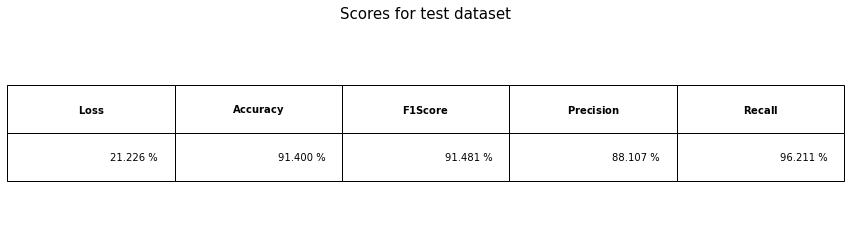

In [17]:
model_evaluation = model.evaluate(dataset_test)


print('Test loss:', model_evaluation[0])
print('Test accuracy:', model_evaluation[1])
print('Test F1 Score :', model_evaluation[2])
print('Test Precision :', model_evaluation[3])
print('Test Recall :', model_evaluation[4])

fig, ax = plt.subplots(1, 1)
column_labels = ["$\\bf{Loss}$",
                 "$\\bf{Accuracy}$",
                 "$\\bf{F1Score}$",
                 "$\\bf{Precision}$",
                 "$\\bf{Recall}$"]
ax.axis('tight')
ax.axis('off')
plt.title('Scores for test dataset', fontsize=15)
table = ax.table(cellText=[['%.3f %%' % (
    i*100) for i in model_evaluation]], colLabels=column_labels, loc="center")
table.scale(2.5, 4)
plt.show()


### Matrice de confusion et ROC 

Interprétation des résultats

In [21]:
def transformPrediction(n):
    return 0 if n < 0.5 else 1

# Partie de génération de matrice de confusion
preds = model.predict(dataset_test)
predicted_categories = list(map(transformPrediction, preds))
true_categories = tf.concat([y for x, y in dataset_test], axis=0)
con_mat = confusion_matrix(predicted_categories, true_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=con_mat)
disp.plot(cmap="red")
plt.title('Confusion Matrix')
plt.show()

# Partie de génération de courbe ROC
fpr, tpr, _ = roc_curve(true_categories, predicted_categories)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='example estimator')
display.plot()
plt.title('ROC Curve')
plt.ylim(0,)
plt.show()

KeyboardInterrupt: 

### Test du modèle

Interprétation des résultats et comment on les test

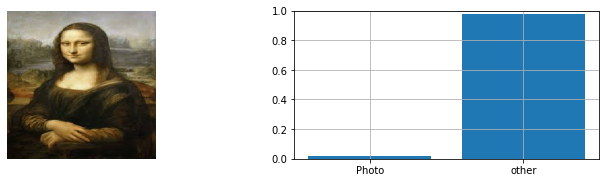

This image is 2.15 % a photo and 97.85 % other.


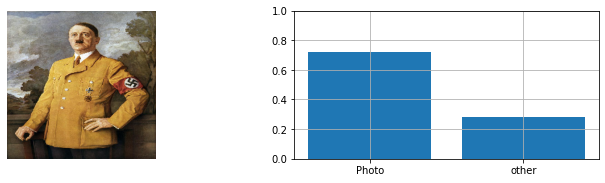

This image is 71.98 % a photo and 28.02 % other.


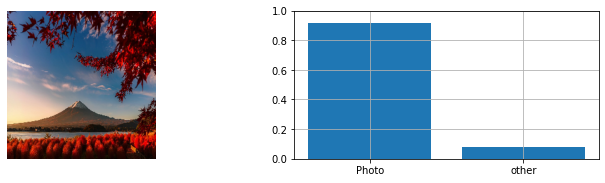

This image is 91.75 % a photo and 8.25 % other.


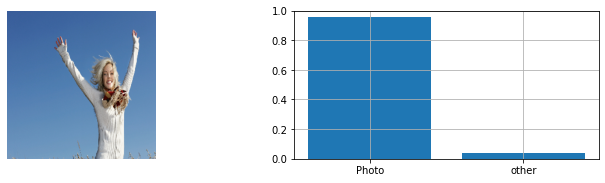

This image is 95.84 % a photo and 4.16 % other.


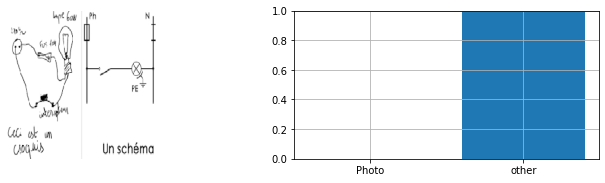

This image is 0.00 % a photo and 100.00 % other.


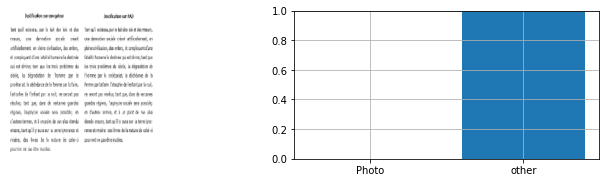

This image is 0.00 % a photo and 100.00 % other.


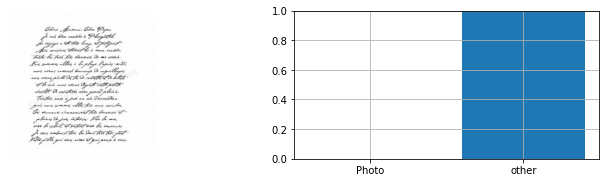

This image is 0.00 % a photo and 100.00 % other.


In [18]:
for pictures in os.listdir(PATH_DATASET_TEST):
    img = image.load_img((PATH_DATASET_TEST + "/" + pictures), target_size = (IMAGE_HEIGHT, IMAGE_WIDTH))
    
    plt.figure(figsize=(12,6))
    plt.subplot(2,2,1)
    plt.axis('off')
    plt.imshow(img, cmap=plt.cm.binary)
    
    img  = image.img_to_array(img)
    img  = img.reshape((1,) + img.shape)
    
    prediction = model.predict(img)

    score = prediction[0][0]
    other_score = (1 - score)

    formatted_photo_score = 100 * score
    formatted_other_score = 100 * other_score

    score_array = [score,other_score]

    plt.subplot(2,2,2)
    plt.grid(True)
    plt.bar(["Photo","autre"], score_array)
    #plt.xticks(range(NB_CLASSES), ["Photo","other"], rotation = 45)
    plt.ylim([0, 1])
    plt.show()
    
    print("Cette image est %.2f %% une photo et %.2f %% autre." % (score*100, other_score*100))
    

### Schéma du modèle 

Sûrement le mettre avant dans la partie modèle et expliquer ce que c'est.

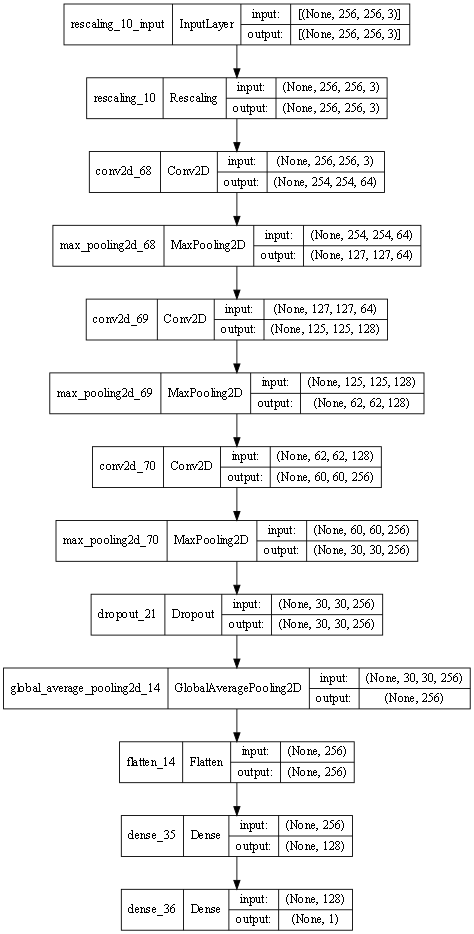

In [19]:
keras.utils.plot_model(model, show_shapes=True, dpi=64)

### Pistes d'amélioration

Early stopping ? Epochs ? Hyperparamètres, tout ce qu'on peux améliorer